In [1]:
import cv2
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [2]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [3]:
wiki_process =  pd.read_csv("data/dataset.csv")

In [4]:
wiki_process.head()

,dob,photo_taken,gender,img_path,face_score1,face_score2,age
0,1982,2009,1.0,wiki_crop/17/10000217_1981-05-05_2009.jpg,4.300962,NaN,27
1,1949,2008,1.0,wiki_crop/12/100012_1948-07-03_2008.jpg,4.329329,NaN,59
2,1972,2012,0.0,wiki_crop/16/10002116_1971-05-31_2012.jpg,3.408442,NaN,40
3,1961,2012,0.0,wiki_crop/02/10002702_1960-11-09_2012.jpg,4.748056,NaN,51
4,1938,1971,1.0,wiki_crop/41/10003541_1937-09-27_1971.jpg,4.184828,NaN,33


In [5]:
len(wiki_process)

59455

In [6]:
start = time.time()

try:  
    with tf.device('/device:GPU:5'):
        image_list = []
        for path in wiki_process["img_path"]:
#             if count == 500:
#                 break
#             else:
            img = cv2.imread("data/" + path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(200,200))
            image_list.append(img)
#                 count += 1
except RuntimeError as e:
  print(e)
end = time.time()
print("time taken for execution :- {}".format(end-start))

time taken for execution :- 516.8129301071167


In [7]:
# wiki_process = wiki_process.head(500)
wiki_process["image"] = image_list
wiki_process.head()

,dob,photo_taken,gender,img_path,face_score1,face_score2,age,image
0,1982,2009,1.0,wiki_crop/17/10000217_1981-05-05_2009.jpg,4.300962,NaN,27,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,1949,2008,1.0,wiki_crop/12/100012_1948-07-03_2008.jpg,4.329329,NaN,59,"[[95, 91, 93, 96, 98, 99, 97, 93, 93, 95, 96, ..."
2,1972,2012,0.0,wiki_crop/16/10002116_1971-05-31_2012.jpg,3.408442,NaN,40,"[[37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 36, ..."
3,1961,2012,0.0,wiki_crop/02/10002702_1960-11-09_2012.jpg,4.748056,NaN,51,"[[121, 121, 121, 122, 122, 122, 123, 123, 123,..."
4,1938,1971,1.0,wiki_crop/41/10003541_1937-09-27_1971.jpg,4.184828,NaN,33,"[[190, 204, 202, 197, 202, 202, 200, 201, 204,..."


In [8]:
wiki_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59455 entries, 0 to 59454
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          59455 non-null  int64  
 1   photo_taken  59455 non-null  int64  
 2   gender       59455 non-null  float64
 3   img_path     59455 non-null  object 
 4   face_score1  59455 non-null  float64
 5   face_score2  0 non-null      float64
 6   age          59455 non-null  int64  
 7   image        59455 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 3.6+ MB


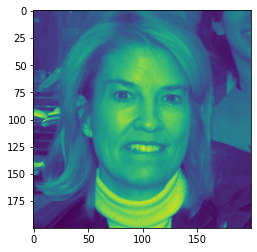

In [9]:
plt.imshow(wiki_process["image"][39454])

In [10]:
#normalizing the pixel values
try:  
    with tf.device('/device:GPU:7'):
        x_data = np.array(image_list)/255
        y_data = wiki_process["gender"].to_numpy()
except RuntimeError as e:
  print(e)

In [11]:
x_data.shape

(59455, 200, 200)

In [12]:
y_data.shape

(59455,)

In [13]:
# image_x will contain the original grayscale images 
x_data = x_data.reshape((x_data.shape[0],200,200,1))

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))

x_data shape: (59455, 200, 200, 1)
y_data shape: (59455,)


In [14]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (39834, 200, 200, 1)
train_y shape: (39834,)

test_x shape: (19621, 200, 200, 1)
test_y shape: (19621,)


In [15]:
# num_subjects = np.unique(y_data).shape[0]
# print("Number of subjects: {}".format(np.unique(y_data).shape[0]))

# Tensorflow

In [22]:
try:  
    with tf.device('/device:GPU:7'):
        # specify the input size of the images
        images = Input((train_x.shape[1], train_x.shape[2], 1,))
        # a convolution layer of 32 filters of size 15x15 to extract features (valid padding)
        x = Conv2D(2,kernel_size=(15,15),padding="valid")(images)
        # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        #  # another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
        x = Conv2D(64,kernel_size=(15,15),padding="valid")(x)
        # # # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        # flatten extracted features to form feature vector
        x = Flatten()(x)
        # a drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # first fully-connected layer to map the features to vectors of size 256
        x = Dense(128,activation="relu")(x)
        # anoter drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # a second fully-connected layer to map the features to a logit vector with one logit per subject
        x = Dense(1)(x)
        # use softmax activation to convert the logits to class probabilities for each subject
        predictions = Activation("sigmoid")(x)

        # create the model using the layers we defined previously
        sample_cnn = Model(inputs=images, outputs=predictions)

        # compile the model so that it uses Adam for optimization during training with cross-entropy loss
        sample_cnn.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["acc"])

        # print out a summary of the model achitecture
        print(sample_cnn.summary())

except RuntimeError as e:
  print(e)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 186, 186, 2)       452       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 93, 93, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 79, 79, 64)        28864     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 97344)             0         
_________________________________________________________________
dropout (Dropout)            (None, 97344)             0     

In [23]:
start = time.time()
# class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)
# class_weights = dict(enumerate(class_weights))
try:  
    with tf.device('/device:GPU:7'):
        # train model
        history = sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=16, batch_size=150, verbose=1)
except RuntimeError as e:
  print(e)
end = time.time()
print("Time spent for training - {}".format(end-start))

Epoch 1/16
266/266 [==============================] - 30s 113ms/step - loss: 0.6100 - acc: 0.6640 - val_loss: 0.5626 - val_acc: 0.7083
Epoch 2/16
266/266 [==============================] - 30s 111ms/step - loss: 0.5474 - acc: 0.7228 - val_loss: 0.5163 - val_acc: 0.7466
Epoch 3/16
266/266 [==============================] - 30s 113ms/step - loss: 0.5091 - acc: 0.7518 - val_loss: 0.4926 - val_acc: 0.7621
Epoch 4/16
266/266 [==============================] - 31s 116ms/step - loss: 0.4803 - acc: 0.7719 - val_loss: 0.4617 - val_acc: 0.7814
Epoch 5/16
266/266 [==============================] - 31s 115ms/step - loss: 0.4529 - acc: 0.7904 - val_loss: 0.4434 - val_acc: 0.7902
Epoch 6/16
266/266 [==============================] - 37s 138ms/step - loss: 0.4301 - acc: 0.8048 - val_loss: 0.4256 - val_acc: 0.8038
Epoch 7/16
266/266 [==============================] - 32s 121ms/step - loss: 0.4099 - acc: 0.8145 - val_loss: 0.4057 - val_acc: 0.8190
Epoch 8/16
266/266 [==============================] - 2

In [41]:
try:  
    with tf.device('/device:GPU:7'):
        test_pred = sample_cnn.predict(test_x)
        for i in test_pred:
            if i[0] >= 0.5:
                i[0] = 1
            else:
                i[0] = 0
        print(test_pred)
except RuntimeError as e:
  print(e)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [42]:
test_pred[test_pred<0.5]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
print(classification_report(test_y,test_pred))
print(confusion_matrix(test_y,test_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.62      0.69      3204
         1.0       0.88      0.94      0.91      9817

    accuracy                           0.86     13021
   macro avg       0.83      0.78      0.80     13021
weighted avg       0.86      0.86      0.86     13021

[[2000 1204]
 [ 578 9239]]


In [52]:
test_y[0]

1.0

In [30]:
# for i in test_pred:
#     if i[0] >= 0.5:
#         i[0] = 1
#     else:
#         i[0] = 0
# test_pred

In [44]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

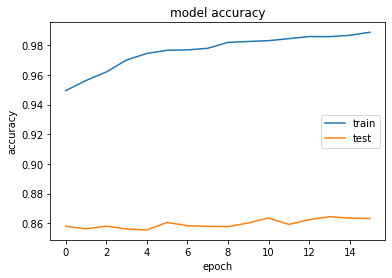

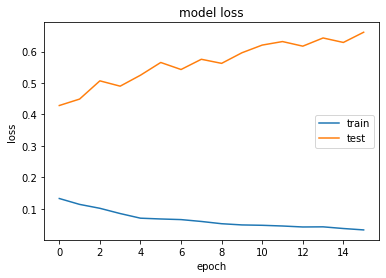

In [60]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

In [63]:
# sample_cnn.save("Project/cnn1_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Project/cnn1_model/assets


In [62]:
history.history['loss']

[0.024247154593467712,
 0.02090921439230442,
 0.01958106830716133,
 0.01675521209836006,
 0.018533067777752876,
 0.015078432857990265,
 0.01690850220620632,
 0.012490777298808098,
 0.014173967763781548,
 0.013455744832754135,
 0.012620748952031136,
 0.012086116708815098,
 0.01181858591735363,
 0.013544703833758831,
 0.012731815688312054,
 0.012506506405770779]

## model 2

In [63]:
try:  
    with tf.device('/device:GPU:7'):
        # specify the input size of the images
        images = Input((train_x.shape[1], train_x.shape[2], 1,))
        # a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
        x = Conv2D(32,kernel_size=(15,15),padding="valid")(images)
        # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        #  # another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
        x = Conv2D(64,kernel_size=(15,15),padding="valid")(x)
        # # # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        # flatten extracted features to form feature vector
        x = Flatten()(x)
        # a drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # first fully-connected layer to map the features to vectors of size 256
        x = Dense(128,activation="relu")(x)
        # anoter drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # a second fully-connected layer to map the features to a logit vector with one logit per subject
        x = Dense(1)(x)
        # use softmax activation to convert the logits to class probabilities for each subject
        predictions = Activation("sigmoid")(x)

        # create the model using the layers we defined previously
        sample_cnn_2 = Model(inputs=images, outputs=predictions)

        # compile the model so that it uses Adam for optimization during training with cross-entropy loss
        sample_cnn_2.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["acc"])

        # print out a summary of the model achitecture
        print(sample_cnn_2.summary())

except RuntimeError as e:
  print(e)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 186, 186, 32)      7232      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 93, 93, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 79, 79, 64)        460864    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 97344)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 97344)             0   

In [64]:
start = time.time()
# class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)
# class_weights = dict(enumerate(class_weights))
try:  
    with tf.device('/device:GPU:7'):
        # train model
        history = sample_cnn_2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=16, batch_size=150, verbose=1)
except RuntimeError as e:
  print(e)
end = time.time()
print("Time spent for training - {}".format(end-start))

Epoch 1/16
177/177 [==============================] - 39s 222ms/step - loss: 0.5467 - acc: 0.7605 - val_loss: 0.5134 - val_acc: 0.7785
Epoch 2/16
177/177 [==============================] - 38s 215ms/step - loss: 0.5059 - acc: 0.7799 - val_loss: 0.5036 - val_acc: 0.7845
Epoch 3/16
177/177 [==============================] - 38s 216ms/step - loss: 0.4807 - acc: 0.7867 - val_loss: 0.4607 - val_acc: 0.7933
Epoch 4/16
177/177 [==============================] - 38s 217ms/step - loss: 0.4625 - acc: 0.7939 - val_loss: 0.4690 - val_acc: 0.7920
Epoch 5/16
177/177 [==============================] - 39s 218ms/step - loss: 0.4465 - acc: 0.8014 - val_loss: 0.5682 - val_acc: 0.7724
Epoch 6/16
177/177 [==============================] - 38s 214ms/step - loss: 0.4331 - acc: 0.8088 - val_loss: 0.4328 - val_acc: 0.8088
Epoch 7/16
177/177 [==============================] - 38s 214ms/step - loss: 0.4183 - acc: 0.8186 - val_loss: 0.4237 - val_acc: 0.8102
Epoch 8/16
177/177 [==============================] - 3

In [70]:
with tf.device('/device:GPU:7'):
    test_pred_2 = sample_cnn_2.predict(test_x)
    test_pred_2 = sample_cnn_2.predict(test_x)
    for i in test_pred_2:
        if i[0] >= 0.5:
            i[0] = 1
        else:
            i[0] = 0
    print(classification_report(test_y,test_pred_2))
    print(confusion_matrix(test_y,test_pred_2))   
    print(confusion_matrix(test_y,test_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.58      0.66      3204
         1.0       0.87      0.95      0.91      9817

    accuracy                           0.86     13021
   macro avg       0.83      0.76      0.79     13021
weighted avg       0.85      0.86      0.85     13021

[[1855 1349]
 [ 525 9292]]
[[2000 1204]
 [ 578 9239]]


## Model using 59455 images for training

In [26]:
try:  
    with tf.device('/device:GPU:6'):
        # specify the input size of the images
        images = Input((train_x.shape[1], train_x.shape[2], 1,))
        # a convolution layer of 32 filters of size 15x15 to extract features (valid padding)
        x = Conv2D(32,kernel_size=(15,15),padding="valid")(images)
        # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        #  # another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
        x = Conv2D(64,kernel_size=(15,15),padding="valid")(x)
        # # # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        # flatten extracted features to form feature vector
        x = Flatten()(x)
        # a drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # first fully-connected layer to map the features to vectors of size 256
        x = Dense(128,activation="relu")(x)
        # anoter drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # a second fully-connected layer to map the features to a logit vector with one logit per subject
        x = Dense(1)(x)
        # use softmax activation to convert the logits to class probabilities for each subject
        predictions = Activation("sigmoid")(x)

        # create the model using the layers we defined previously
        sample_cnn_3 = Model(inputs=images, outputs=predictions)

        # compile the model so that it uses Adam for optimization during training with cross-entropy loss
        sample_cnn_3.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["acc"])

        # print out a summary of the model achitecture
        print(sample_cnn_3.summary())

except RuntimeError as e:
  print(e)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 186, 186, 32)      7232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 93, 93, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 79, 79, 64)        460864    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 97344)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 97344)             0   

In [28]:
start = time.time()
#class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)
#class_weights = dict(enumerate(class_weights))
try:  
    with tf.device('/device:GPU:6'):
        # train model
        history = sample_cnn_3.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=16, batch_size=150, verbose=1)
except RuntimeError as e:
  print(e)
end = time.time()
print("Time spent for training - {}".format(end-start))

Epoch 1/16
266/266 [==============================] - 59s 222ms/step - loss: 0.2456 - acc: 0.8985 - val_loss: 0.3662 - val_acc: 0.8438
Epoch 2/16
266/266 [==============================] - 69s 260ms/step - loss: 0.2308 - acc: 0.9053 - val_loss: 0.3739 - val_acc: 0.8446
Epoch 3/16
266/266 [==============================] - 69s 258ms/step - loss: 0.2178 - acc: 0.9100 - val_loss: 0.3738 - val_acc: 0.8499
Epoch 4/16
266/266 [==============================] - 59s 222ms/step - loss: 0.2045 - acc: 0.9153 - val_loss: 0.3845 - val_acc: 0.8488
Epoch 5/16
266/266 [==============================] - 58s 218ms/step - loss: 0.1963 - acc: 0.9208 - val_loss: 0.3862 - val_acc: 0.8474
Epoch 6/16
266/266 [==============================] - 60s 226ms/step - loss: 0.1875 - acc: 0.9243 - val_loss: 0.4006 - val_acc: 0.8489
Epoch 7/16
266/266 [==============================] - 58s 217ms/step - loss: 0.1748 - acc: 0.9297 - val_loss: 0.4006 - val_acc: 0.8481
Epoch 8/16
266/266 [==============================] - 5

## online

In [20]:
classes = 2
chanDim = -1

In [31]:
try:  
    with tf.device('/device:GPU:7'):
        # specify the input size of the images
        images = Input((train_x.shape[1], train_x.shape[2], 1,))
        x = Conv2D(32,kernel_size=(3,3),padding="same")(images)

        x = Activation("relu")(x)

        x= BatchNormalization(axis=chanDim)(x)
        x= MaxPool2D(pool_size=(3,3))(x)
        x= Dropout(0.25)(x)

        x= Conv2D(64, (3,3), padding="same")(x)
        x= Activation("relu")(x)
        x= BatchNormalization(axis=chanDim)(x)
        x= Conv2D(64, (3,3), padding="same")(x)
        x= Activation("relu")(x)
        x= BatchNormalization(axis=chanDim)(x)
        x= MaxPool2D(pool_size=(2,2))(x)
        x= Dropout(0.25)(x)

        x= Conv2D(128, (3,3), padding="same")(x)
        x= Activation("relu")(x)
        x= BatchNormalization(axis=chanDim)(x)

        x= Conv2D(128, (3,3), padding="same")(x)
        x= Activation("relu")(x)
        x= BatchNormalization(axis=chanDim)(x)
        x= MaxPool2D(pool_size=(2,2))(x)
        x= Dropout(0.25)(x)

        x= Flatten()(x)
        x= Dense(1024)(x)
        x= Activation("relu")(x)
        x= BatchNormalization(axis=chanDim)(x)
        x= Dropout(0.5)(x)

        x= Dense(1)(x)
        
        predictions = Activation("sigmoid")(x)

        # create the model using the layers we defined previously
        model_online = Model(inputs=images, outputs=predictions)

        # compile the model so that it uses Adam for optimization during training with cross-entropy loss
        model_online.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["acc"])

        # print out a summary of the model achitecture
        print(model_online.summary())

except RuntimeError as e:
  print(e)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 200, 200, 32)      320       
_________________________________________________________________
activation_32 (Activation)   (None, 200, 200, 32)      0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 66, 66, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 66, 66, 64)        1849

In [32]:
start = time.time()
#class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)
#class_weights = dict(enumerate(class_weights))
try:  
    with tf.device('/device:GPU:6'):
        # train model
        history = model_online.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=40, batch_size=100, verbose=1)
except RuntimeError as e:
  print(e)
end = time.time()
print("Time spent for training - {}".format(end-start))

Epoch 1/40
399/399 [==============================] - 80s 201ms/step - loss: 0.4635 - acc: 0.7977 - val_loss: 0.5490 - val_acc: 0.7134
Epoch 2/40
399/399 [==============================] - 80s 201ms/step - loss: 0.2913 - acc: 0.8772 - val_loss: 0.3076 - val_acc: 0.8787
Epoch 3/40
399/399 [==============================] - 79s 199ms/step - loss: 0.2617 - acc: 0.8914 - val_loss: 0.3530 - val_acc: 0.8685
Epoch 4/40
399/399 [==============================] - 79s 198ms/step - loss: 0.2391 - acc: 0.9019 - val_loss: 0.3235 - val_acc: 0.8722
Epoch 5/40
399/399 [==============================] - 80s 200ms/step - loss: 0.2078 - acc: 0.9158 - val_loss: 0.3932 - val_acc: 0.8256
Epoch 6/40
399/399 [==============================] - 79s 198ms/step - loss: 0.1825 - acc: 0.9261 - val_loss: 0.2833 - val_acc: 0.8782
Epoch 7/40
399/399 [==============================] - 78s 197ms/step - loss: 0.1712 - acc: 0.9304 - val_loss: 0.2096 - val_acc: 0.9167
Epoch 8/40
399/399 [==============================] - 7

In [33]:
try:  
    with tf.device('/device:GPU:7'):
        test_pred = model_online.predict(test_x)
        for i in test_pred:
            if i[0] >= 0.5:
                i[0] = 1
            else:
                i[0] = 0
        print(test_pred)
except RuntimeError as e:
  print(e)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]


In [42]:
test_pred[test_pred<0.5]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [34]:
print(classification_report(test_y,test_pred))
print(confusion_matrix(test_y,test_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      9790
         1.0       0.92      0.92      0.92      9831

    accuracy                           0.92     19621
   macro avg       0.92      0.92      0.92     19621
weighted avg       0.92      0.92      0.92     19621

[[8958  832]
 [ 756 9075]]


In [54]:
model_online.save('models/new_model.h5')

## Testing over model

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cvlib as cv
import tensorflow as tf
from tensorflow.keras.models import load_model
# from google.colab import  files
# from google.colab.patches import cv2_imshow

In [50]:
video = cv2.VideoCapture('vid1.mp4')  # Sincle colab has no option for live recording, existing file is used

In [51]:
def detect_face_video(img):
    label_dict={0:'Female',1:'Male'}
    color_dict={0:(0,255,0),1:(0,0,255)}
    faces, confidences = cv.detect_face(img) 

    for index,face in enumerate(faces):
        x1,y1 = face[0],face[1]
        x2,y2 = face[2],face[3]
        image = img[y1:y2,x1:x2]
        image_gry = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        resize_img = cv2.resize(image_gry,(200,200))
        norm_img = resize_img/255.0
        reshaped=np.reshape(norm_img,(1,200,200,1))
        #reshaped = np.vstack([reshaped])

        try:  
            with tf.device('/device:GPU:5'):
                gender_res = model_online.predict(reshaped)
        except RuntimeError as e:
            print(e)
        if(gender_res[0][0]<0.5):
            label=0
        else:
            label=1
     
        cv2.rectangle(img,(x1,y1),(x2,y2),color_dict[label],thickness = 5)
#         cv2.rectangle(img,(x1,y1),(x2,y2),color_dict[label],)
        cv2.putText(img, label_dict[label], (x1, y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    return img

In [52]:
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('test3_out.mp4',cv2.VideoWriter_fourcc(*'XVID'),25,(width,height))

* colab gives the output of video files as a series of each frame present in video file

In [53]:
if video.isOpened() == False:
  print('Error! File Not found')
while video.isOpened():
    ret,frame = video.read()
    if ret == True:
        frame = detect_face_video(frame)  #detect the face for each frame displayed on video
        out.write(frame)
#     if cv2.waitKey(27) & 0xFF == ord('q'): #if live webcam is given input then video can be quit using letter 'q'
#         break
    else:
        break
video.release()
out.release()
cv2.destroyAllWindows()